# Unsupervised Learning Recommendation EDSA Movie 

#### Predict #Team FM2 EDSA - Recommenndation algorithm based on content or collaborative filtering
#### Predict how a user will rate a movie 
# TEAM
##### Mosibudi Sehata
##### Ayanda Ndlovu
##### Ayanda Witbooi
##### Thebe Dikobo
##### Maseru Mashiloane
##### Katsila Malepe
##### Vasco Motlalepule Eti

### Table of Contents
---
1. [Introduction](#intro)
 * Background
 * Problem Statement
---
2. [Load Dependencies](#imports)
 * Connecting to Comet
 * Libraries
 * Data
 * Data Definitions
---
3. [Exploratory Data Analysis](#EDA)
 * Data Summary
 * Missing Values
 * Ratings
 * Genres
 * IMDB Metadata
---
4. [Data Preprocessing](#preprocessing)
 * Multidimensional Scaling
 * Principle Component Analysis
 * Cluster Analysis
---
5. [Modelling](#modelling)
 * Collaborative Filtering
 * Content-based Filtering
---
6. [Performance Evaluation](#evaluation)
 * Root Mean Squared Error (RMSE)
 * Cross Validation
---
7. [Model Analysis](#analysis)
 * Hyperparameter Tuning
 * Results
---
8. [Conclusion](#conclusion)
---
9. [Save Output](#ref)
---
10. [References](#save)
--- 

<a id="intro"></a>
## 1. Introduction  

### Background

In today's technology driven world, recommender systems are critical to ensuring users can make appropriate decisions about the content they engage with daily.

Recommender systems help users select similar items when something is being chosen online. Netflix or Amazon would suggest different movies and titles that might interest individual users. In education, these systems may be used to suggest learning material that could improve educational outcomes. These types of algorithms lead to service improvement and customer satisfaction. They do this by addressing the long-tail problem shown below.

<img src="https://www.golegal.co.za/wp-content/uploads/2022/04/Picture2-1.png" width="500" align="center">
    
Customers do not have the time to browse through every available product and businesses cannot simply stop supplying less popular products. A recommender system addresses the long-tail problem by recommending less popular content that the customer is likely to rate highly.

Current recommendation systems - content-based filtering and collaborative  filtering - use difference information sources to make recommendations [[1]](#ref1).

#### Content-based filtering

This method makes recommendations based on user preferences for product features. It is able to recommend new items, but is limited by the need for more data of user preference to improve the quality of recommendations.

#### Collaborative filtering

Collaborative filtering mimics user-to-user recommendations. In other words, If you and your friend have similar tastes, you are likely to make recommendations the other would approve of. This method finds similar users and predicts their preferences as a linear, weighted combination of other user preferences. The limitation is the requirement of a large dataset with active useres who rated a product before in order to make accurate predictions. As a result of this limitation, collaborative systems usually suffer from the "cold start" problem, making predictions for new users challenging. This is usually overcome by using content-based filtering to initiate a user profile.

#### Hybrid systems

A combination of these two recommendations systems is called a hybrid system. They mix the features of the item itself and the preferences of other users [[2]](#ref2).

### Problem Statement
Construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences.

<img src="https://research.aimultiple.com/wp-content/webp-express/webp-images/uploads/2017/08/recommendation-system-800x450.png.webp"
    alt="Dummy image 1"
     style="float: center; padding-bottom=0.5em"
     width=500px/>

<a id="imports"></a>
## 2. Load Dependencies

### Libriaries

In [1]:
#comet section

In [2]:
# Exploratory Data Analysis
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
import random
from time import time
import cufflinks as cf
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Models
from surprise import Reader, Dataset
from surprise import SVD, NormalPredictor, BaselineOnly, NMF, SlopeOne, CoClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Performance Evaluation
from surprise import accuracy
from sklearn.metrics import mean_squared_error
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

### Loading the Data

#### Train and test data:
This is the data used for training and Kaggle submission purposes. The rating is the target variable.

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print(train_df.shape, test_df.shape)
train_df.head()

(10000038, 4) (5000019, 2)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


#### Movie Dataset

In [4]:
movies_df =  pd.read_csv('movies.csv', index_col='movieId')
imdb_df =  pd.read_csv('imdb_data.csv', index_col='movieId')
links_df =  pd.read_csv('links.csv', index_col='movieId')
genome_scores =  pd.read_csv('genome_scores.csv', index_col='movieId')
genome_tags =  pd.read_csv('genome_tags.csv', index_col='tagId')
tags =  pd.read_csv('tags.csv')
print(movies_df.shape, imdb_df.shape, links_df.shape, genome_scores.shape, genome_tags.shape)

(62423, 2) (27278, 5) (62423, 2) (15584448, 2) (1128, 1)


<a id="EDA"></a>
## 3. Exploratory Data Analysis

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [7]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62423 entries, 1 to 209171
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   62423 non-null  object
 1   genres  62423 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [8]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27278 entries, 1 to 131262
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title_cast     17210 non-null  object 
 1   director       17404 non-null  object 
 2   runtime        15189 non-null  float64
 3   budget         7906 non-null   object 
 4   plot_keywords  16200 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.2+ MB


In [9]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62423 entries, 1 to 209171
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   imdbId  62423 non-null  int64  
 1   tmdbId  62316 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.4 MB


In [10]:
genome_scores.head()

,tagId,relevance
movieId,,
1,1,0.02875
1,2,0.02375
1,3,0.06250
1,4,0.07575
1,5,0.14075


In [11]:
genome_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128 entries, 1 to 1128
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tag     1128 non-null   object
dtypes: object(1)
memory usage: 17.6+ KB


In [12]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


In [13]:
print("Train: ")
print(str(train_df.isnull().sum()))
print("============")
print("Test: ")
print(str(test_df.isnull().sum()))
print("============")
print("Movies: ")
print(str(movies_df.isnull().sum()))
# print("============")
# print("Tags: ")
# print(str(tags_df.isnull().sum()))
print("============")
print("Links: ")
print(str(links_df.isnull().sum()))
print("============")
print("IMDB: ")
print(str(imdb_df.isnull().sum()))
print("============")
print("Genome scores: ")
print(str(genome_scores.isnull().sum()))
print("============")
print("Genome tags: ")
print(str(genome_tags.isnull().sum()))
print("============")
print("tags: ")
print(str(tags.isnull().sum()))

Train: 
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Test: 
userId     0
movieId    0
dtype: int64
Movies: 
title     0
genres    0
dtype: int64
Links: 
imdbId      0
tmdbId    107
dtype: int64
IMDB: 
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64
Genome scores: 
tagId        0
relevance    0
dtype: int64
Genome tags: 
tag    0
dtype: int64
tags: 
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64


In [14]:
# Drop missing rows
# tags_df.dropna(axis=0,inplace=True)
links_df.dropna(axis=0,inplace=True)
tags.dropna(axis=0,inplace=True)

we check which users have rated the most movies?

In [15]:
def user_ratings_count(df, n):
    plt.figure(figsize=(12,10))
    data = df['userId'].value_counts().head(n)
    ax = sns.barplot(x = data.index, y = data, order= data.index, palette='brg', edgecolor="black")
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=12, ha='center', va='bottom')
    plt.title(f'Top {n} Users by Number of Ratings', fontsize=14)
    plt.xlabel('User ID')
    plt.ylabel('Number of Ratings')
    print("Combined number of ratings:\t",df['userId'].value_counts().head(n).sum(),
         "\nTotal number of movies:\t\t", df['movieId'].nunique())
    plt.show()

Combined number of ratings:	 38970 
Total number of movies:		 48213


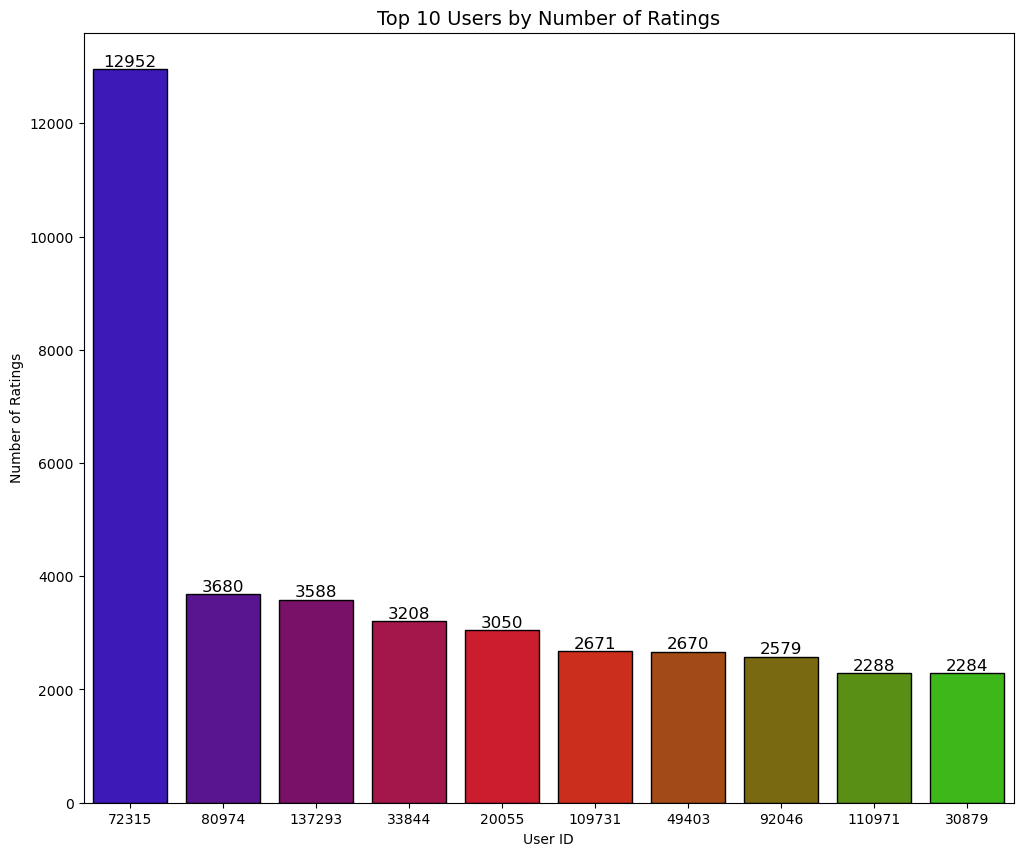

In [16]:
user_ratings_count(train_df,10)

In [17]:
# Exclude user 72315 for EDA
# user 72315 is considered as outlier/anomaly/noise within the data frame.
eda_df = train_df[train_df['userId']!=72315]

Combined number of ratings:	 28296 
Total number of movies:		 45844


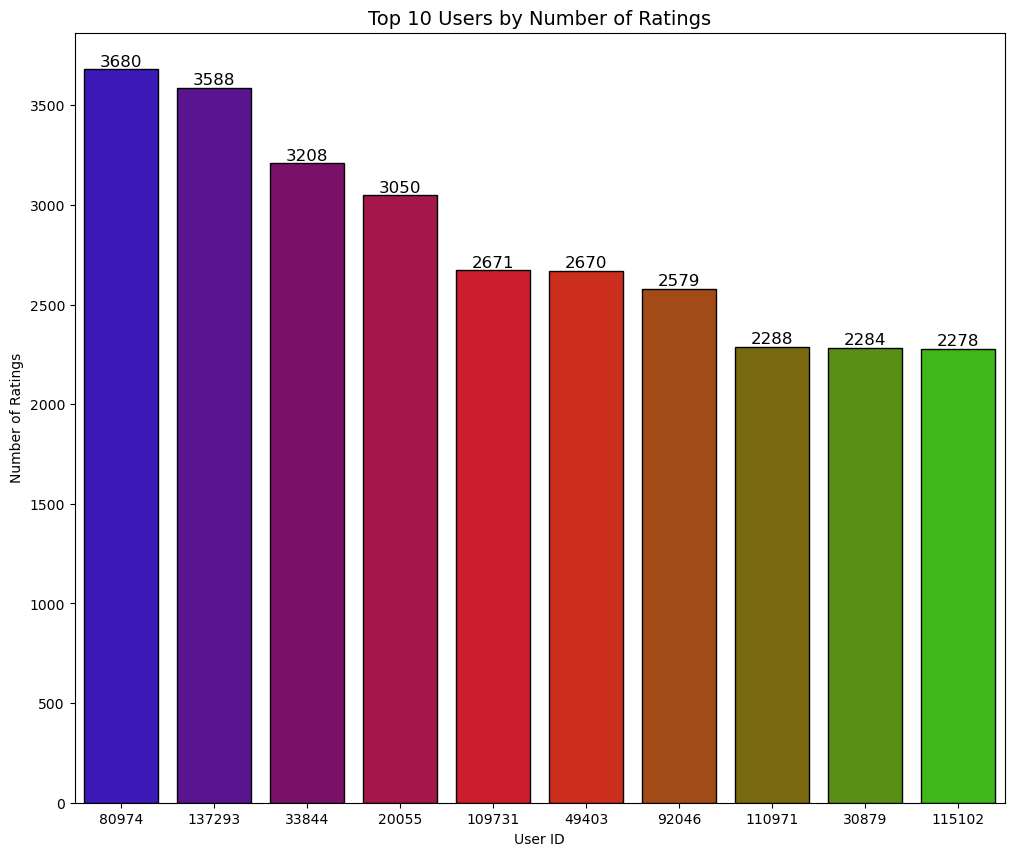

In [18]:
# Distribution of ratings without the outliers
user_ratings_count(eda_df,10)

In [19]:
# How many ratings have we lost?
ratings_lost = 38970 - 28296
print(ratings_lost)  ## ratings lost from removing the outlier

10674


In [20]:
# How many movies were only rated by our outlier?
movies_lost = 48213 -45844
print(movies_lost)   # movies lost from removing the outlier

2369


we check how do users tend to rate movies?

In [21]:
def ratings_distplot(df, column='rating'):
    plt.figure(figsize=(8,6))
    ax = sns.distplot(df[f'{column}'],bins=10, kde=False, hist_kws=dict(alpha=0.6),color="#4D17A0")
    mean = df[f'{column}'].mean()
    median = df[f'{column}'].median()
    plt.axvline(x=mean, label = f'mean {round(mean,2)}' , color='#4D17A0', lw=3, ls = '--')
    plt.axvline(x=median, label = f'median {median}' , color='#4DA017', lw=3, ls = '--')
    plt.xlim((0.5,5))
    plt.ylim((0,2500000))
    plt.title(f'Distribution of Ratings', fontsize=16)
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

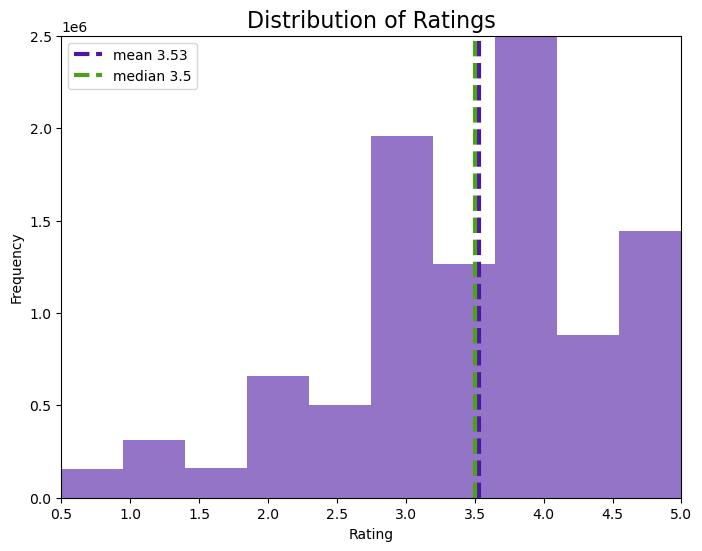

In [22]:
ratings_distplot(eda_df)

the ratings are left-skewed.

we check if there is a relationship between the number of movies a user has rated and the rating that they give?

In [23]:
def mean_ratings_scatter(df, color='#4DA017', column='userId'):
    plt.figure(figsize=(6,4))
    mean_ratings = df.groupby(f'{column}')['rating'].mean()
    user_counts = df.groupby(f'{column}')['movieId'].count().values
    sns.scatterplot(x=mean_ratings, y = user_counts, color=color)
    plt.title(f'Mean Ratings by Number of Ratings', fontsize=14)
    plt.xlabel('Rating')Qs:Here we check if there is a relationship between the number of movies a user has rated and the rating that they give?
    plt.ylabel('Number of Ratings')
    plt.show()

Object `give` not found.


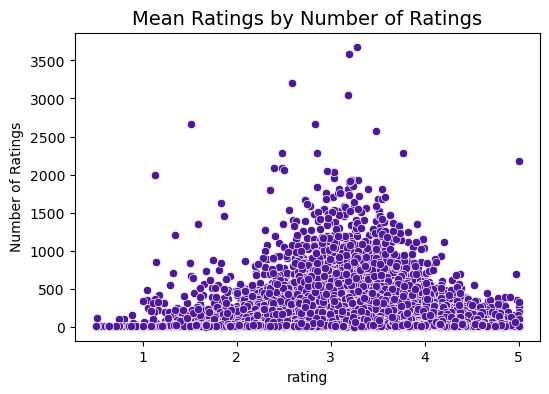

In [24]:
# Mean user ratings by number of ratings
mean_ratings_scatter(eda_df,'#4D17A0')

we check if there is a relationship between the number of ratings a movie has and how highly it is rated?

Object `give` not found.


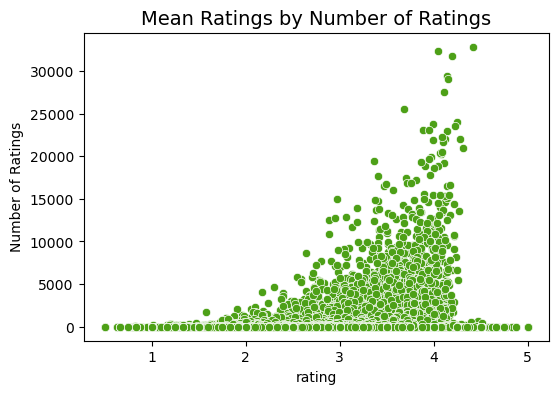

In [25]:
# Mean movie ratings by number of ratings
mean_ratings_scatter(eda_df, column='movieId')

we check which are the best and worst rated movies of all time?

In [26]:
def plot_ratings(count, n, color='#4DA017', best=True, method='mean'):
    # What are the best and worst movies
    # Creating a new DF with mean and count
    if method == 'mean':
        movie_avg_ratings = pd.DataFrame(eda_df.join(movies_df, on='movieId', how='left').groupby(['movieId', 'title'])['rating'].mean())
    else:
        movie_avg_ratings = pd.DataFrame(eda_df.join(movies_df, on='movieId', how='left').groupby(['movieId', 'title'])['rating'].median())
    movie_avg_ratings['count'] = eda_df.groupby('movieId')['userId'].count().values
    movie_avg_ratings.reset_index(inplace=True)
    movie_avg_ratings.set_index('movieId', inplace=True)

    # Remove movies that have been rated fewer than n times
    data = movie_avg_ratings[movie_avg_ratings['count']>count]
    data.sort_values('rating', inplace= True,ascending=False)
    if best == True:
        plot = data.head(n).sort_values('rating', ascending=True)
        title='Best Rated'
    else:
        plot = data.tail(n).sort_values('rating', ascending=False)
        title='Worst Rated'
    plt.figure(figsize=(9,5))
    sns.scatterplot(x=plot['rating'], y=plot['title'], size=plot['count'], color=color)
    plt.xlabel('Rating')
    plt.ylabel('')
    plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
    plt.title(f'Top {n} {title} Movies with Over {count} Ratings', fontsize=20)
    plt.show()

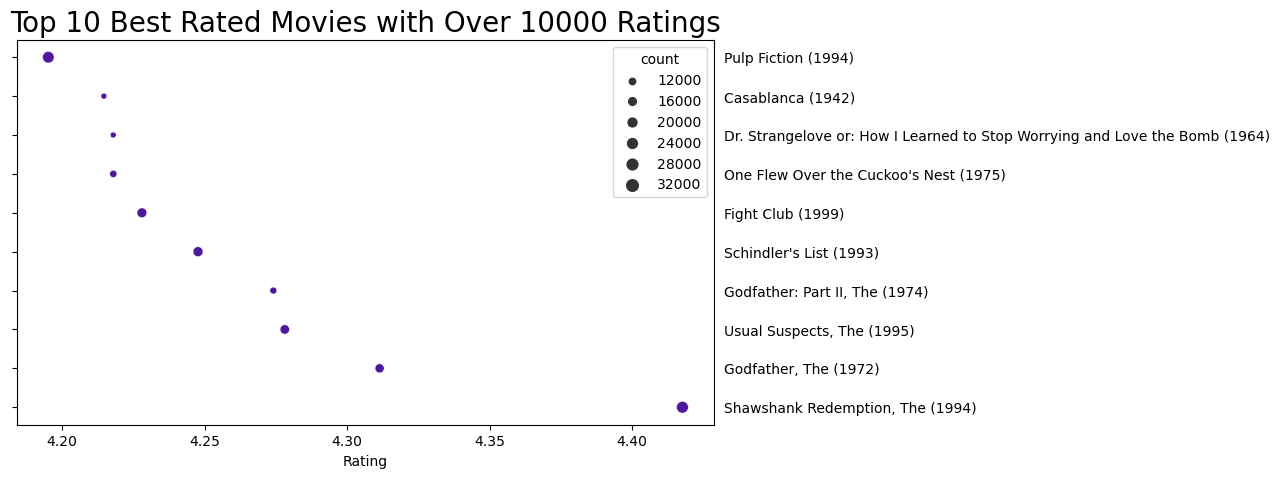

In [27]:
# What are the top 10 highest rated titles?
plot_ratings(10000, 10, '#4D17A0', True, 'mean')

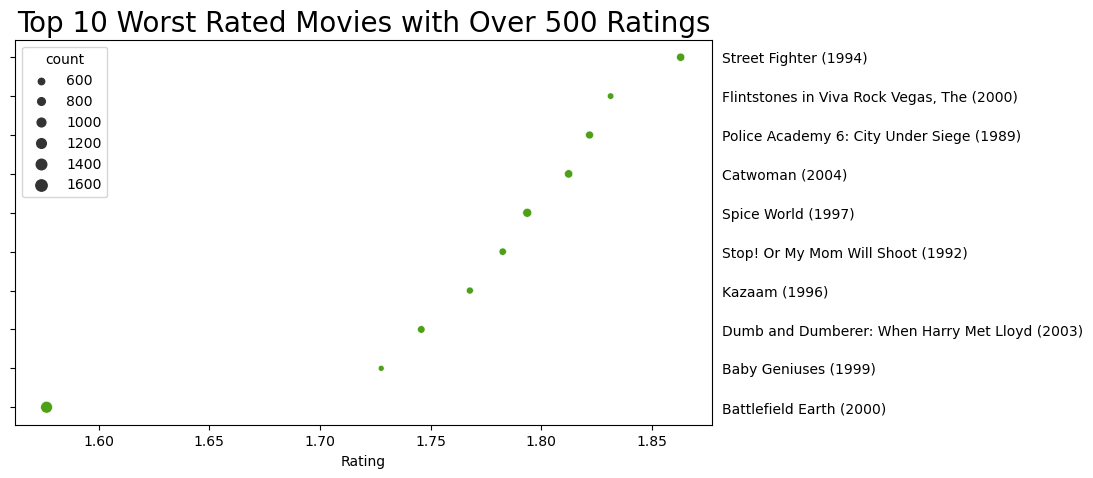

In [28]:
# What are the 10 worst rated titles?
plot_ratings(500, 10,'#4DA017', False, 'mean')

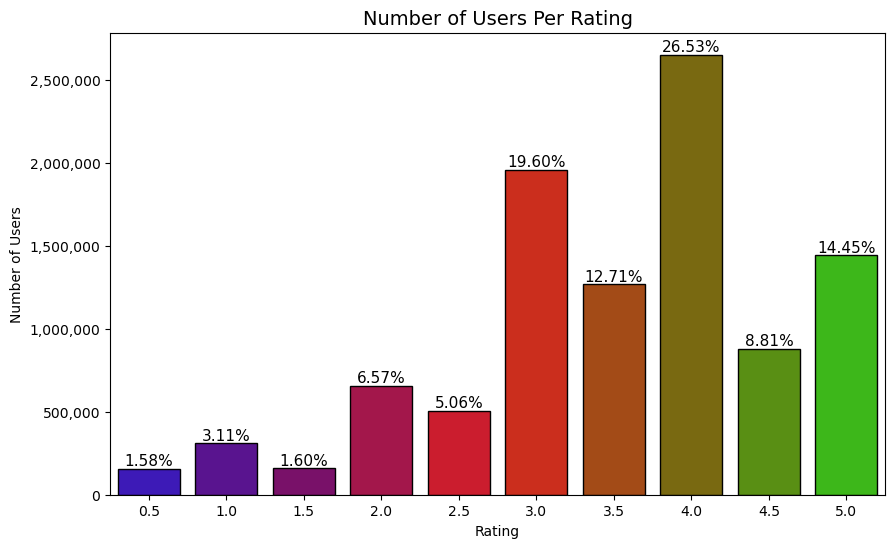

In [29]:
#Percentage of users per rating

movieRatingDistGroup = train_df['rating'].value_counts().sort_index().reset_index()
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=movieRatingDistGroup, x='index', y='rating', palette="brg", edgecolor="black", ax=ax)
ax.set_xlabel("Rating")
ax.set_ylabel('Number of Users')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
total = float(movieRatingDistGroup['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+350, '{0:.2%}'.format(height/total), fontsize=11, ha="center", va='bottom')
plt.title('Number of Users Per Rating', fontsize=14)
plt.show()

In [30]:
def feature_frequency(df, column):
    # Creat a dict to store values
    df = df.dropna(axis=0)
    genre_dict = {f'{column}': list(),
                 'count': list(),}
    # Retrieve a list of all possible genres
    print('retrieving features...')
    for movie in range(len(df)):
        gens = df[f'{column}'].iloc[movie].split('|')
        for gen in gens:
            if gen not in genre_dict[f'{column}']:
                genre_dict[f'{column}'].append(gen)
    # count the number of occurences of each genre
    print('counting...')
    for genre in genre_dict[f'{column}']:
        count = 0
        for movie in range(len(df)):
            gens = df[f'{column}'].iloc[movie].split('|')
            if genre in gens:
                count += 1
        genre_dict['count'].append(count)
        
        # Calculate metrics
    data = pd.DataFrame(genre_dict)
    print('done!')
    return data
genres = feature_frequency(movies_df, 'genres')

retrieving features...
counting...
done!


In [31]:
def feature_count(df, column):
    plt.figure(figsize=(10,6))
    ax = sns.barplot(y = df[f'{column}'], x = df['count'], palette='brg', orient='h')
    plt.title(f'Number of Movies Per {column}', fontsize=14)
    plt.ylabel(f'{column}')
    plt.xlabel('Count')
    plt.show()

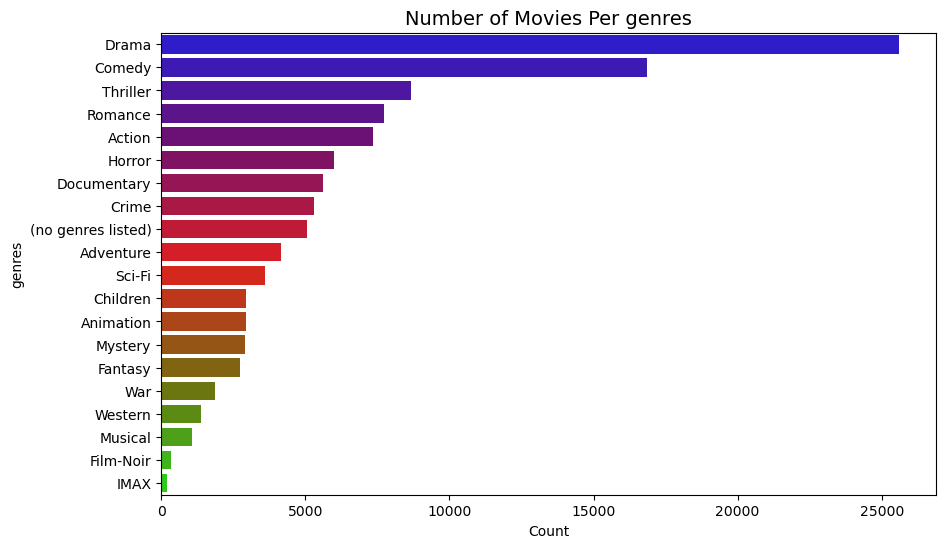

In [32]:
feature_count(genres.sort_values(by = 'count', ascending=False), 'genres')

we check who are the most common directors?

In [33]:
def count_directors(df, count = 10):
    directors = pd.DataFrame(df['director'].value_counts()).reset_index()
    directors.columns = ['director', 'count']
    # Lets only take directors who have made 10 or more movies otherwise we will have to analyze 11000 directors
    directors = directors[directors['count']>=count]
    return directors.sort_values('count', ascending = False)
directors = count_directors(imdb_df)

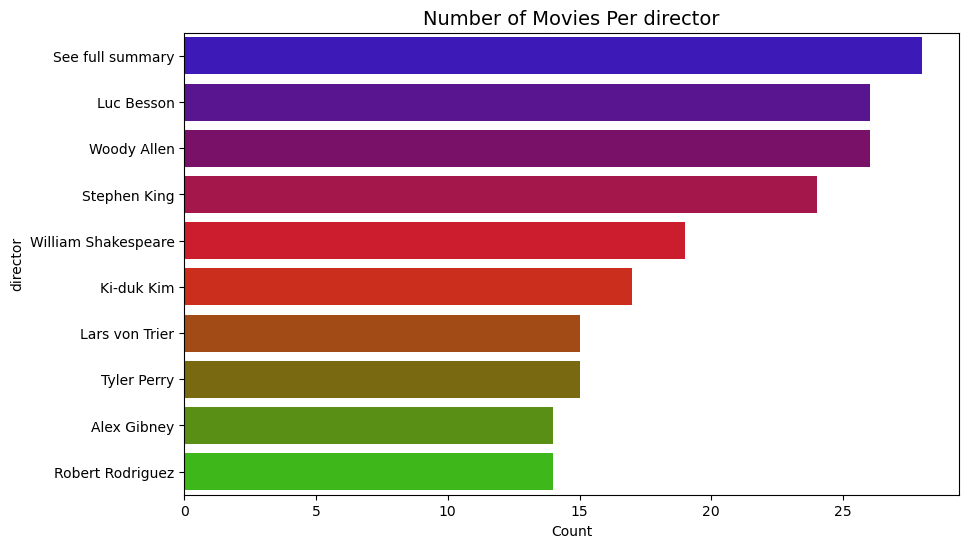

In [34]:
feature_count(directors.head(10), 'director')

In [35]:
def dir_mean(df):
    df.set_index('director', inplace=True)

    direct_ratings = []
    directors_eda = eda_df.join(imdb_df, on = 'movieId', how = 'left')
    for director in df.index:
        rating = round(directors_eda[directors_eda['director']==director]['rating'].mean(),2)
        direct_ratings.append(rating)
    df['mean_rating'] = direct_ratings
    return df.sort_values('mean_rating', ascending = False)

In [36]:
directors = dir_mean(directors)
directors.head()

,count,mean_rating
director,,
Stephen King,24,4.05
Quentin Tarantino,10,3.94
John Sayles,11,3.93
Ki-duk Kim,17,3.89
Pedro Almodóvar,11,3.85


<a id="preprocessing"></a>
## 4. Data Preprocessing

In [37]:
# Subset the data to cut down computation time for now
genome_score = genome_scores[:10000000]

In [38]:
# Although scores are in the range of 0-1, there is no harm in scaling
scaler_mds = StandardScaler()
mds_genome = scaler_mds.fit_transform(genome_score.sample(frac=0.0001))

In [39]:
tsne = TSNE(3, n_jobs = -1, verbose = 2, perplexity = 10, learning_rate = 0.1)

In [40]:
tsne.fit(mds_genome)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.012s...
[t-SNE] Computed neighbors for 1000 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.065634
[t-SNE] Computed conditional probabilities in 0.021s


ValueError: n_components=3 must be between 1 and min(n_samples, n_features)=2 with svd_solver='randomized'

AttributeError: 'TSNE' object has no attribute 'embedding_'

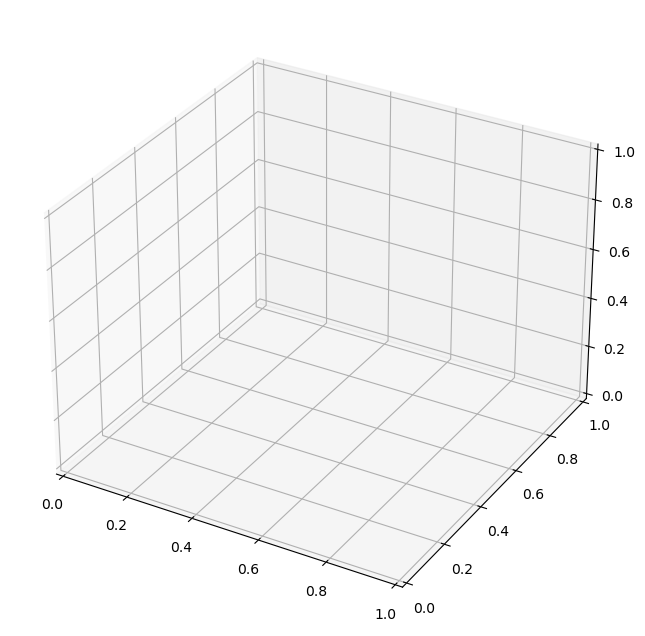

In [41]:
Axes3D

fig = plt.figure(figsize=(15, 8))

# Add 3D scatter plot
ax = fig.add_subplot(projection='3d')
ax.scatter(tsne.embedding_[:,0], tsne.embedding_[:,1], tsne.embedding_[:,2], color='#4D17A0')
plt.show()

In [42]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x = tsne.embedding_[:,0], y = tsne.embedding_[:,1], size=tsne.embedding_[:,2],color='#4DA017')
plt.show()

AttributeError: 'TSNE' object has no attribute 'embedding_'

<Figure size 800x600 with 0 Axes>